# Univariate Distribution Fitting & PIT for Stock Returns

**Period:** 2010–2025  
**Goal:** For each stock's daily log-returns, fit candidate univariate distributions (Normal / Student‑t / Empirical), select the best one with information criteria and goodness-of-fit tests, and transform series using the Probability Integral Transform (PIT) to obtain Uniform(0,1) margins.

### What you get
1. A per‑ticker best marginal model with parameters.
2. PIT‑transformed returns (Uniform(0,1)).
3. Diagnostic plots and tables to validate fits.

### Expected input format
- A CSV file with **rows = dates** and **columns = tickers**, values are **daily log‑returns**.
- First column can be a Date column (will be parsed). Example header: `date,AAPL,MSFT,AMZN,...`

### Outputs (saved to disk)
- `best_marginals.csv`: per‑ticker best model and parameters.
- `pit_uniform.parquet` *(if pyarrow available)* or `pit_uniform.csv.gz`: PIT series for each ticker.
- Optional per‑ticker plots rendered in‑notebook.


In [1]:
# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

print('Versions:')
print('numpy', np.__version__)
print('pandas', pd.__version__)
import scipy, statsmodels
print('scipy', scipy.__version__)
print('statsmodels', statsmodels.__version__)

Versions:
numpy 1.26.4
pandas 2.2.3
scipy 1.12.0
statsmodels 0.14.4


## 1) Load data
Update `data_path` to your CSV file. The notebook assumes daily **log‑returns** as input.

In [3]:
from pathlib import Path

data_path = Path('../data/sp500_log_returns.csv')
def load_returns_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Try to parse a date column if present
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    # Ensure numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    # Drop completely empty columns
    df = df.dropna(axis=1, how='all')
    return df

returns = load_returns_csv(data_path)
print('Loaded returns from:', data_path)
print('Shape:', returns.shape)
returns.head(3)

Loaded returns from: ../data/sp500_log_returns.csv
Shape: (3982, 503)


,PODD,ALLE,KMB,FITB,WSM,FRT,DIS,MRK,BAX,INVH,...,USB,WFC,EMR,XYZ,TAP,ACGL,RSG,BBY,NSC,ES
0,-0.001998,NaN,0.000778,0.026330,0.027464,-0.001195,-0.002498,0.004045,-0.006886,NaN,...,0.025034,0.027082,0.001613,NaN,-0.012050,-0.003341,0.001394,0.025063,0.015285,-0.003499
1,-0.022246,NaN,-0.012359,0.005758,0.034882,-0.002692,-0.005328,0.013366,0.003449,NaN,...,0.010600,0.001424,0.008942,NaN,-0.001103,-0.004332,0.007630,-0.007796,-0.002813,0.012768
2,0.008823,NaN,-0.006633,0.058540,0.046704,-0.000300,0.000314,0.001592,0.016052,NaN,...,0.019216,0.035642,0.000000,NaN,-0.016912,-0.005900,-0.001729,0.015772,-0.013233,-0.001539


## 2) Fitting helpers & model selection criteria
We fit **Normal** and **Student‑t** parametrically; **Empirical** is kept as a fallback when both parametric fits fail goodness‑of‑fit.

**Criteria:**
- Log‑likelihood (higher is better)
- AIC/BIC (lower is better)
- Goodness‑of‑fit tests: **Kolmogorov–Smirnov (KS)** and **Cramér–von Mises (CvM)** using fitted CDF

Decision rule per ticker:
1. Compare Normal vs t by AIC/BIC.
2. If both KS/CvM reject (p<0.05), prefer **Empirical**.
3. If t's df is small (e.g., <10), it strongly indicates heavy tails; bias toward **t** when criteria are close.


In [4]:
from typing import Dict, Tuple

def fit_normal(x: np.ndarray) -> Tuple[float, float]:
    # MLE for normal equals sample mean/std (unbiased std is close; we use MLE style with ddof=0)
    mu = np.mean(x)
    sigma = np.std(x, ddof=0)
    # guard against zero sigma
    sigma = sigma if sigma > 1e-12 else 1e-12
    return mu, sigma

def fit_t(x: np.ndarray) -> Tuple[float, float, float]:
    # scipy.stats.t.fit returns (df, loc, scale)
    df, loc, scale = stats.t.fit(x)
    # guard
    if scale <= 1e-12:
        scale = 1e-12
    if df < 2.01:
        df = 2.01  # ensure finite variance
    return df, loc, scale

def loglik_normal(x: np.ndarray, mu: float, sigma: float) -> float:
    return np.sum(stats.norm.logpdf(x, loc=mu, scale=sigma))

def loglik_t(x: np.ndarray, df: float, loc: float, scale: float) -> float:
    return np.sum(stats.t.logpdf(x, df=df, loc=loc, scale=scale))

def aic(loglik: float, k: int) -> float:
    return 2*k - 2*loglik

def bic(loglik: float, k: int, n: int) -> float:
    return k*np.log(n) - 2*loglik

def gof_pvalues(x: np.ndarray, cdf_callable) -> Tuple[float, float]:
    # KS test with fitted CDF
    ks_stat, ks_p = stats.kstest(x, cdf_callable)
    # Cramer–von Mises test
    cvm_res = stats.cramervonmises(x, cdf_callable)
    cvm_p = getattr(cvm_res, 'pvalue', np.nan)
    return ks_p, cvm_p

def empirical_pit(x: np.ndarray) -> np.ndarray:
    # Plotting position (rank - 0.5)/n to avoid 0/1
    order = np.argsort(x)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(x)+1)
    u = (ranks - 0.5)/len(x)
    return u


## 3) Run fitting & selection across tickers
This cell loops through all columns (tickers), fits Normal & t, computes AIC/BIC and KS/CvM, then selects the best model or falls back to Empirical if needed.

In [5]:
best_rows = []
pit_df = pd.DataFrame(index=returns.index)

for col in returns.columns:
    x = returns[col].dropna().values
    n = len(x)
    if n < 20:
        continue  # skip very short series

    # Fit Normal
    mu, sigma = fit_normal(x)
    ll_norm = loglik_normal(x, mu, sigma)
    aic_norm = aic(ll_norm, k=2)
    bic_norm = bic(ll_norm, k=2, n=n)
    norm_cdf = lambda s: stats.norm.cdf(s, loc=mu, scale=sigma)
    ks_norm, cvm_norm = gof_pvalues(x, norm_cdf)

    # Fit Student‑t
    df_t, loc_t, scale_t = fit_t(x)
    ll_t = loglik_t(x, df_t, loc_t, scale_t)
    aic_t = aic(ll_t, k=3)
    bic_t = bic(ll_t, k=3, n=n)
    t_cdf = lambda s: stats.t.cdf(s, df=df_t, loc=loc_t, scale=scale_t)
    ks_t, cvm_t = gof_pvalues(x, t_cdf)

    # Select between Normal and t using information criteria first
    choose_t = (aic_t + bic_t) < (aic_norm + bic_norm)
    # bias towards t if very heavy tails
    if df_t < 10 and (abs(aic_t - aic_norm) + abs(bic_t - bic_norm)) < 10:
        choose_t = True

    # If both tests reject badly for both, use Empirical
    both_bad = ( (ks_norm < 0.05 and cvm_norm < 0.05) and (ks_t < 0.05 and cvm_t < 0.05) )

    if both_bad:
        best = 'empirical'
        params = {}
        # PIT via empirical ranks (aligned to original index)
        series = returns[col].dropna()
        u = pd.Series(empirical_pit(series.values), index=series.index)
    else:
        if choose_t:
            best = 't'
            params = {'df': df_t, 'loc': loc_t, 'scale': scale_t}
            series = returns[col].dropna()
            u = pd.Series(stats.t.cdf(series.values, df=df_t, loc=loc_t, scale=scale_t), index=series.index)
        else:
            best = 'normal'
            params = {'mu': mu, 'sigma': sigma}
            series = returns[col].dropna()
            u = pd.Series(stats.norm.cdf(series.values, loc=mu, scale=sigma), index=series.index)

    # Clip to (1e-6, 1-1e-6) to avoid exact 0/1
    u = u.clip(1e-6, 1-1e-6)
    pit_df[col] = u.reindex(returns.index)

    best_rows.append({
        'ticker': col,
        'n': n,
        'best_model': best,
        'mu': params.get('mu', np.nan),
        'sigma': params.get('sigma', np.nan),
        't_df': params.get('df', np.nan),
        't_loc': params.get('loc', np.nan),
        't_scale': params.get('scale', np.nan),
        'll_norm': ll_norm,
        'aic_norm': aic_norm,
        'bic_norm': bic_norm,
        'ks_p_norm': ks_norm,
        'cvm_p_norm': cvm_norm,
        'll_t': ll_t,
        'aic_t': aic_t,
        'bic_t': bic_t,
        'ks_p_t': ks_t,
        'cvm_p_t': cvm_t
    })

best_table = pd.DataFrame(best_rows).set_index('ticker').sort_values(['best_model','n'], ascending=[True, False])
best_table.head(10)

/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_87293/3169685280.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pit_df[col] = u.reindex(returns.index)
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_87293/3169685280.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pit_df[col] = u.reindex(returns.index)
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_87293/3169685280.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

,n,best_model,mu,sigma,t_df,t_loc,t_scale,ll_norm,aic_norm,bic_norm,ks_p_norm,cvm_p_norm,ll_t,aic_t,bic_t,ks_p_t,cvm_p_t
ticker,,,,,,,,,,,,,,,,,
GS,3982,empirical,NaN,NaN,NaN,NaN,NaN,10310.622861,-20617.245723,-20604.666644,2.258961e-14,3.522693e-11,10650.495208,-21294.990417,-21276.121798,5.376059e-08,3.554192e-09
SW,3982,empirical,NaN,NaN,NaN,NaN,NaN,8851.273284,-17698.546568,-17685.967489,0.000000e+00,3.238132e-08,4963.638885,-9921.277770,-9902.409151,0.000000e+00,3.469578e-08
NXPI,3833,empirical,NaN,NaN,NaN,NaN,NaN,8443.556156,-16883.112312,-16870.609505,3.624575e-15,2.648204e-11,8797.887078,-17589.774156,-17571.019947,7.762038e-03,4.417195e-02
AMCR,3386,empirical,NaN,NaN,NaN,NaN,NaN,9286.051874,-18568.103748,-18555.848939,2.614681e-151,2.652156e-08,-39363.594980,78733.189961,78751.572174,8.220058e-255,1.205738e-08
PODD,3982,t,NaN,NaN,3.494249,0.000981,0.017013,8952.267299,-17900.534598,-17887.955519,1.919308e-16,5.885141e-10,9367.142722,-18728.285444,-18709.416825,9.307735e-01,9.362814e-01
KMB,3982,t,NaN,NaN,3.512423,0.000631,0.007703,12103.074709,-24202.149419,-24189.570340,1.360347e-17,1.085211e-09,12528.807364,-25051.614728,-25032.746109,7.382029e-01,5.581384e-01
FITB,3982,t,NaN,NaN,3.042261,0.000765,0.013517,9572.030408,-19140.060816,-19127.481737,5.213458e-23,9.980006e-11,10096.093510,-20186.187021,-20167.318402,8.756875e-01,9.575193e-01
WSM,3982,t,NaN,NaN,3.324693,0.000833,0.015939,9024.121744,-18044.243489,-18031.664410,1.431920e-19,6.883922e-10,9562.899423,-19119.798845,-19100.930227,9.804939e-01,9.793847e-01
FRT,3982,t,NaN,NaN,3.178659,0.000493,0.009857,10706.333463,-21408.666926,-21396.087847,3.719464e-24,4.324519e-09,11415.816153,-22825.632306,-22806.763688,4.613705e-01,4.969588e-01


## 4) Save outputs
We save the **best marginal models** and the **PIT-transformed series**. Parquet preferred if available.

In [5]:
out_dir = Path('/Users/ziranguo/Desktop/MQF/2025 Fall/Risk Management/Project')
best_csv = out_dir / 'best_marginals.csv'
pit_parquet = out_dir / 'pit_uniform.parquet'
pit_csv_gz = out_dir / 'pit_uniform.csv.gz'

best_table.to_csv(best_csv)
print('Saved best_marginals.csv ->', best_csv)

saved = None
try:
    import pyarrow  # noqa: F401
    pit_df.to_parquet(pit_parquet)
    saved = str(pit_parquet)
except Exception as e:
    pit_df.to_csv(pit_csv_gz, compression='gzip')
    saved = str(pit_csv_gz)
print('Saved PIT ->', saved)

Saved best_marginals.csv -> /Users/ziranguo/Desktop/MQF/2025 Fall/Risk Management/Project/best_marginals.csv
Saved PIT -> /Users/ziranguo/Desktop/MQF/2025 Fall/Risk Management/Project/pit_uniform.parquet


## 5) Diagnostics: single‑ticker visuals
Use these helpers to visually check a chosen ticker. Each plot is a **single chart** as required.

In [6]:
def plot_hist_with_fit(series: pd.Series, meta_row: pd.Series):
    x = series.dropna().values
    plt.figure()
    plt.hist(x, bins=50, density=True)
    plt.title(f"Histogram with fitted PDF — {series.name} ({meta_row['best_model']})")
    plt.show()

def plot_pit_hist(pit_series: pd.Series):
    u = pit_series.dropna().values
    plt.figure()
    plt.hist(u, bins=50, density=True)
    plt.title(f"PIT histogram (should look Uniform) — {pit_series.name}")
    plt.show()

def qq_plot(series: pd.Series, meta_row: pd.Series):
    x = np.sort(series.dropna().values)
    n = len(x)
    p = (np.arange(1, n+1) - 0.5)/n
    if meta_row['best_model'] == 'normal':
        q = stats.norm.ppf(p, loc=meta_row['mu'], scale=meta_row['sigma'])
    elif meta_row['best_model'] == 't':
        q = stats.t.ppf(p, df=meta_row['t_df'], loc=meta_row['t_loc'], scale=meta_row['t_scale'])
    else:
        # For empirical, compare to its own quantiles (should be close to identity)
        q = np.quantile(x, p)
    plt.figure()
    plt.scatter(q, x, s=4)
    plt.title(f"QQ plot — {series.name} vs {meta_row['best_model']}")
    plt.show()


### Example: visualize a ticker (edit the ticker symbol)

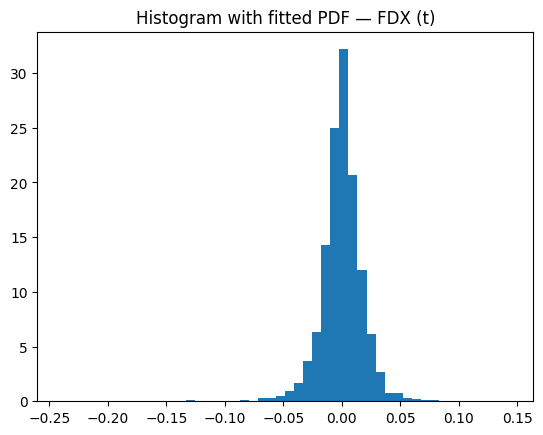

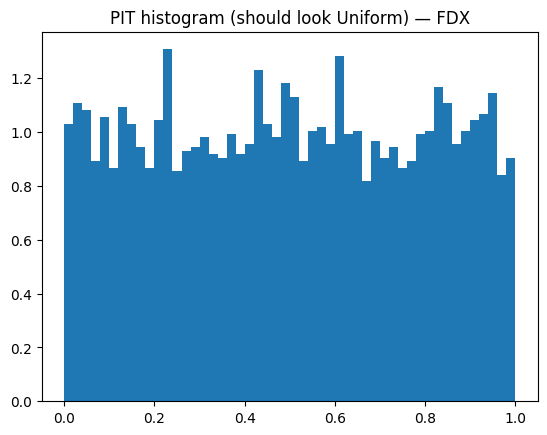

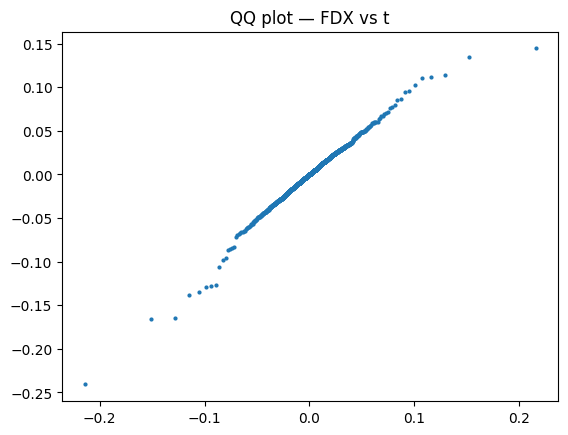

In [7]:
ticker = returns.columns[2]
series = returns[ticker]
meta_row = best_table.loc[ticker]
plot_hist_with_fit(series, meta_row)
plot_pit_hist(pit_df[ticker].rename(ticker))
qq_plot(series, meta_row)

## 6) Next steps
- Use `pit_df` to build **copula models** (Gaussian / t / Vine) separating marginals from dependence.
- Examine **tail dependence** and regime changes using rolling PIT or copula parameters.
- Integrate with portfolio risk: draw copula samples, re‑apply inverse CDF per ticker, and simulate P&L.
